本教程提供了有关如何使用加载图像数据集的简单示例tf.data。

本示例中使用的数据集作为图像目录分发，每个目录具有一类图像。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
# 如果使用值tf.data.experimental.AUTOTUNE，则根据可用的CPU动态设置并行调用的数量。
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [5]:
tf.__version__

'2.0.0'

## 1、加载图像

检索图像

在开始任何培训之前，您将需要一组图像来向网络传授要识别的新课程。您可以使用Google创作的具有常见创意许可的花朵照片档案。

In [6]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

下载（218MB）之后，您现在应该已经可以使用花卉照片的副本。

该目录包含5个子目录，每个类一个：

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [8]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

array（['雏菊'，'玫瑰'，'蒲公英'，'向日葵'，'郁金香']，
      dtype ='<U10'）

每个目录都包含该花类型的图像。这是一些玫瑰：

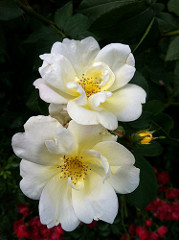

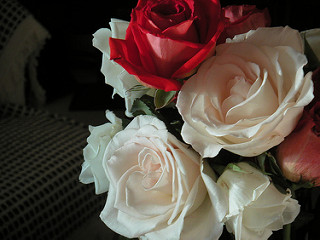

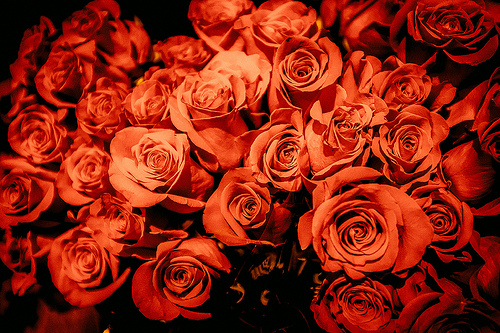

In [9]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## 2、通过`keras.preprocessing`加载图像

加载使用 keras.preprocessing

加载图像的一种简单方法是使用tf.keras.preprocessing。

In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

为加载程序定义一些参数：

In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


检查一批：

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

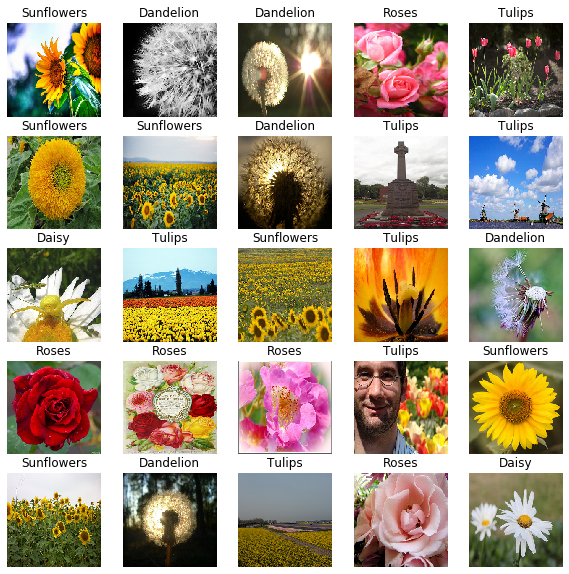

In [14]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## 3、使用`tf.data`加载图片

加载使用 tf.data<br>
上面的keras.preprocessing方法很方便，但是有两个缺点：
1. 太慢了 请参阅下面的性能部分。
1. 它缺乏细粒度的控制。
1. 它没有与TensorFlow的其余部分很好地集成。

要首先加载文件，请tf.data.Dataset创建文件路径的数据集：

In [15]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [16]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\30660\\.keras\\datasets\\flower_photos\\dandelion\\3372748508_e5a4eacfcb_n.jpg'
b'C:\\Users\\30660\\.keras\\datasets\\flower_photos\\daisy\\13953307149_f8de6a768c_m.jpg'
b'C:\\Users\\30660\\.keras\\datasets\\flower_photos\\tulips\\5043225469_0aa23f3c8f_n.jpg'
b'C:\\Users\\30660\\.keras\\datasets\\flower_photos\\sunflowers\\210076535_80951bc5d5.jpg'
b'C:\\Users\\30660\\.keras\\datasets\\flower_photos\\dandelion\\14614655810_9910e6dbd6_n.jpg'


编写一个简短的pure-tensorflow函数，该函数将文件路径转换为（image_data，label）对：

In [38]:
# 获取标签
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '\\')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [39]:
# 解析图片数据
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [40]:
# 根据路径加载图片
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

使用Dataset.map创建的数据集image, label对：

In [41]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [42]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False  True]


## 4、`keras.preprocessing`和`tf.data`的性能对比，以及`tf.data`不使用缓存和使用缓存文件的性能展示

基本训练方法
要使用该数据集训练模型，您将需要以下数据：

* 要好好洗牌。
* 待批处理。
* 批量尽快供货。

这些功能可以使用tf.dataapi 轻松添加。

In [56]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
# This is a small dataset, only load it once, and keep it in memory.
# use `.cache(filename)` to cache preprocessing work for datasets that don't
# fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [57]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

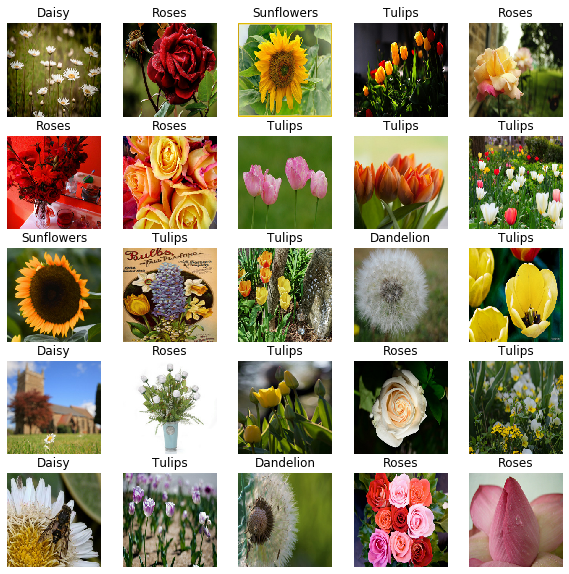

In [58]:
show_batch(image_batch.numpy(), label_batch.numpy())

为了进行调查，首先这里是一个检查数据集性能的函数：

In [59]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.',end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

让我们比较两个数据生成器的速度：

In [60]:
# `keras.preprocessing`
timeit(train_data_gen)

....................................................................................................
1000 batches: 65.01055860519409 s
492.22773 Images/s


In [61]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 13.80066180229187 s
2318.72938 Images/s


性能提升的很大一部分来自使用.cache。

In [64]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 47.242806911468506 s
677.35179 Images/s


如果数据集无法容纳在内存中，请使用缓存文件来维护一些优势：

In [65]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 43.850850343704224 s
729.74640 Images/s


## 1、中文教程的迁移学习案例

下载并检查数据集<br>
检索图片<br>
在你开始任何训练之前，你将需要一组图片来教会网络你想要训练的新类别。你已经创建了一个文件夹，存储了最初使用的拥有创作共用许可的花卉照片。

In [15]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

C:\Users\sha\.keras\datasets\flower_photos


下载了 218 MB 之后，你现在应该有花卉照片副本：

In [16]:
for item in data_root.iterdir():
    print(item)

C:\Users\sha\.keras\datasets\flower_photos\daisy
C:\Users\sha\.keras\datasets\flower_photos\dandelion
C:\Users\sha\.keras\datasets\flower_photos\LICENSE.txt
C:\Users\sha\.keras\datasets\flower_photos\roses
C:\Users\sha\.keras\datasets\flower_photos\sunflowers
C:\Users\sha\.keras\datasets\flower_photos\tulips


In [17]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

检查图片<br>
现在让我们快速浏览几张图片，这样你知道你在处理什么：

In [18]:
all_image_paths[:10]

['C:\\Users\\sha\\.keras\\datasets\\flower_photos\\daisy\\3379332157_04724f6480.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\roses\\18584002386_cec0df537d_n.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\daisy\\9489270024_1b05f08492_m.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\tulips\\14122029097_3e3285ca5c_n.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\roses\\3556123230_936bf084a5_n.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\sunflowers\\184682506_8a9b8c662d.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\roses\\14880561916_79aeb812fd_n.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\sunflowers\\821368661_4ab4343f5a.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\roses\\1793211631_68c31a74dc.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\roses\\5156037859_1673720a11_m.jpg']

In [19]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [47]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    # 注意此处 windos和linux的不同
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel).replace('\\','/')].split(' - ')[:-1])

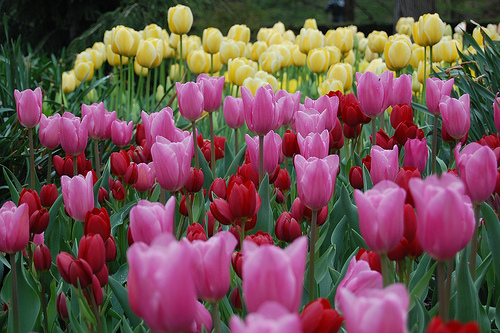

Image (CC BY 2.0)  by PS-OV-ART Patty Sue O'Hair-Vicknair, Artist



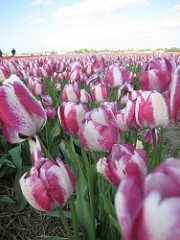

Image (CC BY 2.0)  by Amy Bonner



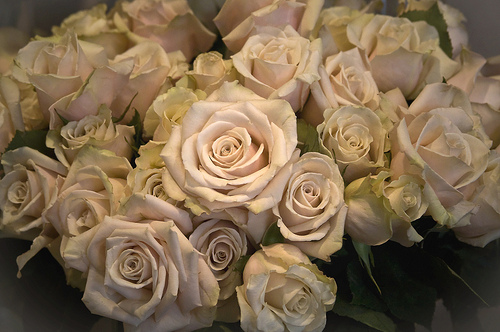

Image (CC BY 2.0)  by liz west



In [48]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

确定每张图片的标签<br>
列出可用的标签：

In [49]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

为每个标签分配索引：

In [50]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

创建一个列表，包含每个文件的标签索引：

In [51]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 2, 0, 4, 2, 3, 2, 3, 2, 2]


加载和格式化图片<br>
TensorFlow 包含加载和处理图片时你需要的所有工具：

In [52]:
img_path = all_image_paths[0]
img_path

'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\daisy\\3379332157_04724f6480.jpg'

以下是原始数据：

In [53]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\...


将它解码为图像 tensor（张量）：

In [54]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(327, 500, 3)
<dtype: 'uint8'>


根据你的模型调整其大小：

In [55]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


将这些包装在一个简单的函数里，以备后用。

In [56]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image

In [57]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

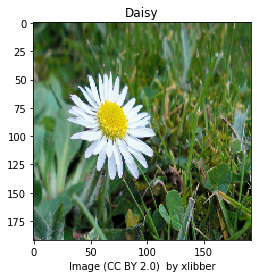

In [58]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

构建一个 tf.data.Dataset<br>
一个图片数据集<br>
构建 tf.data.Dataset 最简单的方法就是使用 from_tensor_slices 方法。

将字符串数组切片，得到一个字符串数据集：

In [59]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [60]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


现在创建一个新的数据集，通过在路径数据集上映射 preprocess_image 来动态加载和格式化图片。

In [61]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

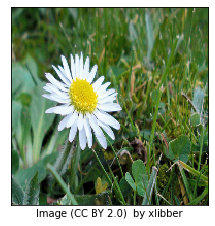

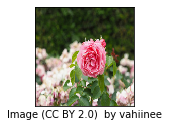

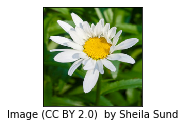

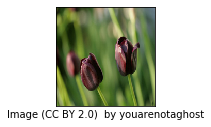

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()

一个(图片, 标签)对数据集<br>
使用同样的 from_tensor_slices 方法你可以创建一个标签数据集：

In [63]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [131]:
for label in label_ds.take(10):
    print(label.numpy())

0
2
0
4
2
3
2
3
2
2


In [64]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

daisy
roses
daisy
tulips
roses
sunflowers
roses
sunflowers
roses
roses


由于这些数据集顺序相同，你可以将他们打包在一起得到一个(图片, 标签)对数据集：

In [65]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

这个新数据集的 shapes（维数） 和 types（类型） 也是维数和类型的元组，用来描述每个字段：

In [66]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


注意：当你拥有形似 all_image_labels 和 all_image_paths 的数组，tf.data.dataset.Dataset.zip 的替代方法是将这对数组切片。

In [132]:
all_image_paths[:5]

['C:\\Users\\sha\\.keras\\datasets\\flower_photos\\daisy\\3379332157_04724f6480.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\roses\\18584002386_cec0df537d_n.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\daisy\\9489270024_1b05f08492_m.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\tulips\\14122029097_3e3285ca5c_n.jpg',
 'C:\\Users\\sha\\.keras\\datasets\\flower_photos\\roses\\3556123230_936bf084a5_n.jpg']

In [133]:
all_image_labels[:5]

[0, 2, 0, 4, 2]

In [136]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

训练的基本方法
要使用此数据集训练模型，你将会想要数据：

* 被充分打乱。
* 被分割为 batch。
* 永远重复。
* 尽快提供 batch。

使用 tf.data api 可以轻松添加这些功能。

In [137]:
BATCH_SIZE = 32

# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
# 被充分打乱。
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

这里有一些注意事项：

1. 顺序很重要。

    * 在 .repeat 之后 .shuffle，会在 epoch 之间打乱数据（当有些数据出现两次的时候，其他数据还没有出现过）。

    * 在 .batch 之后 .shuffle，会打乱 batch 的顺序，但是不会在 batch 之间打乱数据。

1. 你在完全打乱中使用和数据集大小一样的 buffer_size（缓冲区大小）。较大的缓冲区大小提供更好的随机化，但使用更多的内存，直到超过数据集大小。

1. 在从随机缓冲区中拉取任何元素前，要先填满它。所以当你的 Dataset（数据集）启动的时候一个大的 buffer_size（缓冲区大小）可能会引起延迟。

1. 在随机缓冲区完全为空之前，被打乱的数据集不会报告数据集的结尾。Dataset（数据集）由 .repeat 重新启动，导致需要再次等待随机缓冲区被填满。

最后一点可以通过使用 tf.data.Dataset.apply 方法和融合过的 tf.data.experimental.shuffle_and_repeat 函数来解决:

In [138]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

传递数据集至模型
从 tf.keras.applications 取得 MobileNet v2 副本。

该模型副本会被用于一个简单的迁移学习例子。

设置 MobileNet 的权重为不可训练：

In [70]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 295s 31us/step


In [78]:
# ! pip install -q keras_applications

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [79]:
import keras_applications

In [80]:
help(keras_applications.mobilenet_v2.preprocess_input)

Help on function preprocess_input in module keras_applications.mobilenet_v2:

preprocess_input(x, **kwargs)
    Preprocesses a numpy array encoding a batch of images.
    
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    
    # Returns
        Preprocessed array.



在你将输出传递给 MobilNet 模型之前，你需要将其范围从 [0,1] 转化为 [-1,1]：

In [81]:
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

MobileNet 为每张图片的特征返回一个 6x6 的空间网格。

传递一个 batch 的图片给它，查看结果：

In [82]:
# 数据集可能需要几秒来启动，因为要填满其随机缓冲区。
image_batch, label_batch = next(iter(keras_ds))

In [83]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


构建一个包装了 MobileNet 的模型并在 tf.keras.layers.Dense 输出层之前使用 tf.keras.layers.GlobalAveragePooling2D 来平均那些空间向量：

In [134]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

现在它产出符合预期 shape(维数)的输出：

In [135]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.0046281377
max logit: 0.9099541

Shape: (32, 5)


编译模型以描述训练过程：

In [139]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

此处有两个可训练的变量 —— Dense 层中的 weights（权重） 和 bias（偏差）：

In [140]:
len(model.trainable_variables)

2

In [141]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


你已经准备好来训练模型了。

注意，出于演示目的每一个 epoch 中你将只运行 3 step，但一般来说在传递给 model.fit() 之前你会指定 step 的真实数量，如下所示：

In [89]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [143]:
model.fit(ds, epochs=10, steps_per_epoch=50)

Train for 50 steps
Epoch 1/10
50/50 [==============================] - 28s 557ms/step - loss: 1.0679 - accuracy: 0.5894
Epoch 2/10
50/50 [==============================] - 7s 145ms/step - loss: 0.6064 - accuracy: 0.7819
Epoch 3/10
50/50 [==============================] - 7s 149ms/step - loss: 0.4919 - accuracy: 0.8213
Epoch 4/10
50/50 [==============================] - 8s 151ms/step - loss: 0.4353 - accuracy: 0.8381
Epoch 5/10
50/50 [==============================] - 7s 142ms/step - loss: 0.3709 - accuracy: 0.8750
Epoch 6/10
50/50 [==============================] - 8s 151ms/step - loss: 0.3528 - accuracy: 0.8750
Epoch 7/10
50/50 [==============================] - 7s 142ms/step - loss: 0.3490 - accuracy: 0.8744
Epoch 8/10
50/50 [==============================] - 7s 145ms/step - loss: 0.2986 - accuracy: 0.8944
Epoch 9/10
50/50 [==============================] - 7s 142ms/step - loss: 0.3154 - accuracy: 0.8925
Epoch 10/10
50/50 [==============================] - 7s 148ms/step - loss: 0.300

## 2、性能对比

性能<br>
注意：这部分只是展示一些可能帮助提升性能的简单技巧。深入指南，请看：输入 pipeline（管道）的性能。

上面使用的简单 pipeline（管道）在每个 epoch 中单独读取每个文件。在本地使用 CPU 训练时这个方法是可行的，但是可能不足以进行 GPU 训练并且完全不适合任何形式的分布式训练。

要研究这点，首先构建一个简单的函数来检查数据集的性能：

In [91]:
import time
default_timeit_steps = 2*steps_per_epoch+1

def timeit(ds, steps=default_timeit_steps):
    overall_start = time.time()
    # 在开始计时之前
    # 取得单个 batch 来填充 pipeline（管道）（填充随机缓冲区）
    it = iter(ds.take(steps+1))
    next(it)

    start = time.time()
    for i,(images,labels) in enumerate(it):
        if i%10 == 0:
            print('.',end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
    print("Total time: {}s".format(end-overall_start))

当前数据集的性能是：

In [92]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [93]:
timeit(ds)

........................
231.0 batches: 17.8696448802948 s
413.66239 Images/s
Total time: 25.72800874710083s


缓存<br>
使用 tf.data.Dataset.cache 在 epoch 之间轻松缓存计算结果。这是非常高效的，特别是当内存能容纳全部数据时。

在被预处理之后（解码和调整大小），图片在此被缓存了：

In [94]:
ds = image_label_ds.cache()
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [95]:
timeit(ds)

........................
231.0 batches: 1.6935887336730957 s
4364.69602 Images/s
Total time: 10.02637505531311s


使用内存缓存的一个缺点是必须在每次运行时重建缓存，这使得每次启动数据集时有相同的启动延迟：

In [96]:
timeit(ds)

........................
231.0 batches: 1.8001973628997803 s
4106.21644 Images/s
Total time: 1.8211660385131836s


如果内存不够容纳数据，使用一个缓存文件：

In [97]:
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(1)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [98]:
timeit(ds)

........................
231.0 batches: 7.233977317810059 s
1021.84451 Images/s
Total time: 27.48360514640808s


这个缓存文件也有可快速重启数据集而无需重建缓存的优点。注意第二次快了多少：

In [99]:
timeit(ds)

........................
231.0 batches: 6.19261908531189 s
1193.67910 Images/s
Total time: 8.847273826599121s


## 3、TFRecord 文件

### 保存未经处理的原始二进制图片

原始图片数据<br>
TFRecord 文件是一种用来存储一串二进制 blob 的简单格式。通过将多个示例打包进同一个文件内，TensorFlow 能够一次性读取多个示例，当使用一个远程存储服务，如 GCS 时，这对性能来说尤其重要。

首先，从原始图片数据中构建出一个 TFRecord 文件：

In [118]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.io.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

接着，构建一个从 TFRecord 文件读取的数据集，并使用你之前定义的 preprocess_image 函数对图像进行解码/重新格式化：

In [119]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

压缩该数据集和你之前定义的标签数据集以得到期望的 (图片,标签) 对：

In [120]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [121]:
timeit(ds)

........................
231.0 batches: 14.501935005187988 s
509.72508 Images/s
Total time: 20.678568840026855s


这比 缓存 版本慢，因为你还没有缓存预处理。

In [122]:
ds = tf.data.Dataset.zip((image_ds.cache(), label_ds.cache()))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [123]:
timeit(ds)

........................
231.0 batches: 1.658313512802124 s
4457.54071 Images/s
Total time: 7.908914089202881s


### 保存处理过的图片

序列化的 Tensor（张量）<br>
要为 TFRecord 文件省去一些预处理过程，首先像之前一样制作一个处理过的图片数据集：

In [144]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

<MapDataset shapes: (192, 192, 3), types: tf.float32>

现在你有一个 tensor（张量）数据集，而不是一个 .jpeg 字符串数据集。

要将此序列化至一个 TFRecord 文件你首先将该 tensor（张量）数据集转化为一个字符串数据集：

In [145]:
ds = image_ds.map(tf.io.serialize_tensor)
ds

<MapDataset shapes: (), types: tf.string>

In [146]:
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

有了被缓存的预处理，就能从 TFrecord 文件高效地加载数据——只需记得在使用它之前反序列化：

In [147]:
ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
    result = tf.io.parse_tensor(x, out_type=tf.float32)
    result = tf.reshape(result, [192, 192, 3])
    return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
ds

<ParallelMapDataset shapes: (192, 192, 3), types: tf.float32>

现在，像之前一样添加标签和进行相同的标准操作：

In [148]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [149]:
timeit(ds)

........................
231.0 batches: 7.897982835769653 s
935.93518 Images/s
Total time: 12.106846570968628s


In [150]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds=ds.cache()
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: (((None, None, 192, 192, 3), (None, None)), (None,)), types: ((tf.float32, tf.int64), tf.int64)>

In [151]:
timeit(ds)

ResourceExhaustedError: Failed to allocate memory for the batch of component 0 [Op:IteratorGetNextSync]